In [387]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot

from six.moves import cPickle as pickle
from datetime import datetime
import os
import sys
import time

import numpy as np
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import tensorflow as tf

/Users/alex/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [388]:
sys.setrecursionlimit(10000)  # for pickle...

In [389]:
FTRAIN = '~/ML/kaggle/facial-keypoints-detection/data/training.csv'
FTEST = '~/ML/kaggle/facial-keypoints-detection/data/test.csv'
FLOOKUP = '~/ML/kaggle/facial-keypoints-detection/data/IdLookupTable.csv'

In [390]:
def load(test = False, cols = None):
#     Loads data from FTEST if *test* is True, otherwise from FTRAIN.
#     Pass a list of *cols* if you're only interested in a subset of the
#     target columns.
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [391]:
image_size = 96
num_channels = 1 # grayscale
num_keypoints = 30

def load2d(test = False, cols = None):
    X, y = load(test = test)
    X = X.reshape(-1, num_channels, image_size, image_size)
    return X, y

In [392]:
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

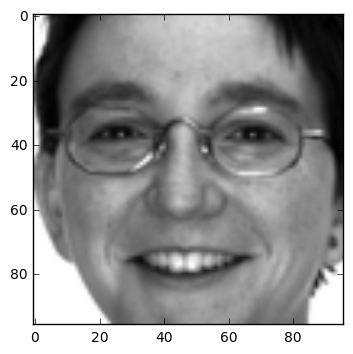

In [7]:
img = X[11].reshape(96, 96)
pyplot.imshow(img, cmap='gray')
pyplot.show()

In [394]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

In [16]:
x_reshaped = x_train.reshape(x_train.shape[0], image_size*image_size)

In [18]:
x_reshaped.shape

(1498, 1, 96, 96)

In [393]:
y.shape

(2140, 30)

In [108]:
def calc_score(predictions, labels):
    return np.sqrt(np.mean(np.square(predictions - labels))) * 48.0

In [109]:
def calc_loss(predictions, labels):
    return np.mean(np.square(predictions - labels))

In [255]:
def get_time_hhmmss(start):
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## First model: a single hidden layer

Routine that performs a single layer pass, e.g. returns `input * weights + bias`:

In [441]:
def layer_pass(input, shape):
    weights = tf.get_variable( 'weights', 
        shape = shape,
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [shape[1]],
        initializer=tf.constant_initializer(0.0)
        )
    return tf.matmul(input, weights) + biases

Routine that performs entire model pass, e.g. returns model prediction for given input:

In [445]:
def model_pass(input):
    with tf.variable_scope('hidden'):
        hidden = layer_pass(input, [image_size * image_size, hidden_layer_size])
    relu_hidden = tf.nn.relu(hidden)
    with tf.variable_scope('out'):
        prediction = layer_pass(relu_hidden, [hidden_layer_size, num_keypoints])
    return prediction

Model parameters:

In [515]:
# Predefined parameters
batch_size = 36
hidden_layer_size = 100
l2_lambda = 0
num_epochs = 400
learning_rate = 0.01
momentum = 0.9

# Calculated parameters
num_steps_in_epoch = int((y_train.shape[0] + batch_size) / batch_size)
num_steps = num_steps_in_epoch * num_epochs

In [516]:
graph = tf.Graph()

with graph.as_default():
# Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (batch_size, num_keypoints))

    tf_x_valid = tf.constant(x_val.reshape(x_val.shape[0], image_size * image_size))
    tf_x_test = tf.constant(x_test.reshape(x_test.shape[0], image_size * image_size))
    tf_x_train = tf.constant(x_train.reshape(x_train.shape[0], image_size * image_size))

    global_step = tf.Variable(0)  # count the number of steps taken.

# Model parameters.
    #learning_rate = tf.train.exponential_decay(0.5, global_step, decay_steps = num_steps, decay_rate = 0.99)

# Training computation.
    with tf.variable_scope("single_hidden_layer_model"):
        pred = model_pass(tf_x_batch)
    
    loss = tf.reduce_mean(tf.square(pred - tf_y_batch)) # + l2_lambda * (tf.nn.l2_loss(weightsInToHid) + tf.nn.l2_loss(weightsHidToOut))  
    
# Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(
        loss, 
        global_step = global_step
    )

# Predictions for the training, validation, and test data. 
    with tf.variable_scope("single_hidden_layer_model", reuse = True):
        p_train = model_pass(tf_x_train)  
        p_valid = model_pass(tf_x_valid)  
        p_test = model_pass(tf_x_test)

In [517]:
start = time.time()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    train_loss = np.ndarray(num_epochs + 1)
    valid_loss = np.ndarray(num_epochs + 1)
    for step in range(num_steps):
        epoch = int((step + 1) / num_steps_in_epoch)
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = x_train[offset:(offset + batch_size), :].reshape(batch_size, image_size * image_size)
        batch_labels = y_train[offset:(offset + batch_size), :]
        _, l, predictions = session.run(
            [optimizer, loss, pred], 
            feed_dict = {
                tf_x_batch : batch_data, 
                tf_y_batch : batch_labels
            }
        )

        global_step = step
        if (offset < batch_size):
            # Start of the new epoch
            train_loss[epoch] = calc_loss(p_train.eval(), y_train)
            valid_loss[epoch] = calc_loss(p_valid.eval(), y_val)
            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("  Minibatch loss: %.8f" % (l))
                print("      Train loss: %.8f" % (train_loss[epoch]))
                print(" Validation loss: %.8f" % (valid_loss[epoch]))
                print("            Time: " + get_time_hhmmss(start))
    print("===================================")
    print(" Test score: %.3f" % calc_score(p_test.eval(), y_test))  
    print(" Total time: " + get_time_hhmmss(start))

--------- EPOCH    0/400 ---------
  Minibatch loss: 0.41892129
      Train loss: 0.64503527
 Validation loss: 0.67398000
            Time: 00:00:00
--------- EPOCH  100/400 ---------
  Minibatch loss: 0.00483115
      Train loss: 0.00335462
 Validation loss: 0.00455376
            Time: 00:00:21
--------- EPOCH  200/400 ---------
  Minibatch loss: 0.00355210
      Train loss: 0.00252154
 Validation loss: 0.00379237
            Time: 00:00:42
--------- EPOCH  300/400 ---------
  Minibatch loss: 0.00259072
      Train loss: 0.00206733
 Validation loss: 0.00328994
            Time: 00:01:04
 Test score: 2.877
 Total time: 00:01:27


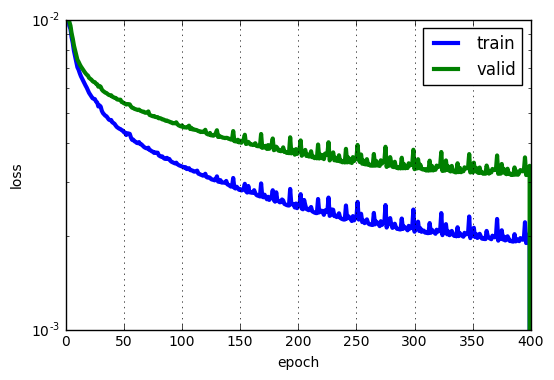

In [518]:
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.001, 0.01)
pyplot.yscale("log")
pyplot.show()